### Getting data Ready

In [1]:
import os
from glob import glob
import numpy as np # for file pattern matching
import nibabel as nib # for working with neuroimaging data in NIfTI format
import matplotlib.pyplot as plt

In [2]:
import torch

In [3]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [4]:
TRAIN_DATASET_PATH = './BraTS2021_Training_Data/'

#### ***Preprocessing:***
It iterates over each image in the dataset:
- load **image** and scale its intensity values to the range [0, 1] using Min-Max scaling
- combine three MRI modalities (T2, T1ce, FLAIR) into a single 4D array
- replace label 4 with label 3 in **segmentation mask**
- crops the images and masks to a size divisible by 64 to facilitate later extraction of 64x64x64 patches
- checks if the **mask** contains at least 1% useful volume with labels other than 0 and if this condition is met, it converts the masks to categorical format
- saves the image and mask as numpy arrays

In [5]:
t2_list = sorted(glob('BraTS2021_Training_Data/*/*t2.nii.gz'))
# glob returns a list of paths matching the given pattern != from os.listdir that does not return entire paths
print('t2_list', t2_list)

t1ce_list = sorted(glob('BraTS2021_Training_Data/*/*t1ce.nii.gz'))

flair_list = sorted(glob('BraTS2021_Training_Data/*/*flair.nii.gz'))

mask_list = sorted(glob('BraTS2021_Training_Data/*/*seg.nii.gz'))


#Each volume generates 18 64x64x64x4 sub-volumes. ???????
#Total 369 volumes = 6642 sub volumes

for img in range(200):   #Using t2_list as all lists are of same size
    print("Now preparing image and masks number: ", img)
      
    temp_image_t2=nib.load(t2_list[img]).get_fdata()
    temp_image_t2=scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)
   
    temp_image_t1ce=nib.load(t1ce_list[img]).get_fdata()
    temp_image_t1ce=scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)
   
    temp_image_flair=nib.load(flair_list[img]).get_fdata()
    temp_image_flair=scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)
        
    temp_mask=nib.load(mask_list[img]).get_fdata()
    temp_mask=temp_mask.astype(np.uint8)
    temp_mask[temp_mask==4] = 3  
    
    temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)
    
    # Crop to a size to be divisible by 64
    #temp_combined_images=temp_combined_images[24:216, 24:216, 13:141]
    #temp_mask = temp_mask[24:216, 24:216, 13:141]
    temp_combined_images=temp_combined_images[56:184, 56:184, 13:141]
    temp_mask = temp_mask[56:184, 56:184, 13:141]
    
    val, counts = np.unique(temp_mask, return_counts=True)
    
    if (1 - (counts[0]/counts.sum())) > 0.01:  #At least 1% useful volume with labels that are not 0
        print("Save Me")
        temp_mask_one_hot = torch.zeros((*temp_mask.shape, 4), dtype=torch.float32)
        temp_mask_one_hot.scatter_(3, torch.unsqueeze(torch.tensor(temp_mask, dtype=torch.int64), 3), 1)

        output_dir = 'BraTS2021_TrainingData/input_data_3channels'
        image_dir = os.path.join(output_dir, 'images')
        mask_dir = os.path.join(output_dir, 'masks')
        os.makedirs(image_dir, exist_ok=True)
        os.makedirs(mask_dir, exist_ok=True)
        np.save('BraTS2021_TrainingData/input_data_3channels/images/image_'+str(img)+'.npy', temp_combined_images)
        np.save('BraTS2021_TrainingData/input_data_3channels/masks/mask_'+str(img)+'.npy', temp_mask_one_hot)
        
    else:
        print("I am useless") 
   
     
################################################################
# Repeat the same from above for validation data folder OR
# Split training data into train and validation

"""
NOW: splitting folder into train, test, and val.
Once the new folders are created rename them and arrange in the format below to be used
for semantic segmentation using data generators. 
"""
import splitfolders  # or import split_folders

input_folder = 'BraTS2021_TrainingData/input_data_3channels/'
output_folder = 'BraTS2021_TrainingData/input_data_128/'

# Split with a ratio.
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.8, .2), group_prefix=None) # default values

t2_list ['BraTS2021_Training_Data\\BraTS2021_00002\\BraTS2021_00002_t2.nii.gz', 'BraTS2021_Training_Data\\BraTS2021_00003\\BraTS2021_00003_t2.nii.gz', 'BraTS2021_Training_Data\\BraTS2021_00005\\BraTS2021_00005_t2.nii.gz', 'BraTS2021_Training_Data\\BraTS2021_00006\\BraTS2021_00006_t2.nii.gz', 'BraTS2021_Training_Data\\BraTS2021_00008\\BraTS2021_00008_t2.nii.gz', 'BraTS2021_Training_Data\\BraTS2021_00009\\BraTS2021_00009_t2.nii.gz', 'BraTS2021_Training_Data\\BraTS2021_00011\\BraTS2021_00011_t2.nii.gz', 'BraTS2021_Training_Data\\BraTS2021_00012\\BraTS2021_00012_t2.nii.gz', 'BraTS2021_Training_Data\\BraTS2021_00014\\BraTS2021_00014_t2.nii.gz', 'BraTS2021_Training_Data\\BraTS2021_00016\\BraTS2021_00016_t2.nii.gz', 'BraTS2021_Training_Data\\BraTS2021_00017\\BraTS2021_00017_t2.nii.gz', 'BraTS2021_Training_Data\\BraTS2021_00018\\BraTS2021_00018_t2.nii.gz', 'BraTS2021_Training_Data\\BraTS2021_00019\\BraTS2021_00019_t2.nii.gz', 'BraTS2021_Training_Data\\BraTS2021_00020\\BraTS2021_00020_t2.nii.gz

IndexError: list index out of range

#### NOW we try the previous pre-processing pipeline on a single image-mask pair

- load **image** and scale its intensity values to the range [0, 1] using Min-Max scaling
- replace label 4 with label 3 in **segmentation mask**

In [22]:
temp_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_00211/BraTS2021_00211_t2.nii.gz').get_fdata()
temp_image_t2=scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)

temp_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_00211/BraTS2021_00211_t1ce.nii.gz').get_fdata()
temp_image_t1ce=scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)

temp_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_00211/BraTS2021_00211_flair.nii.gz').get_fdata()
temp_image_flair=scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)
    
temp_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_00211/BraTS2021_00211_seg.nii.gz').get_fdata()
temp_mask=temp_mask.astype(np.uint8)
temp_mask[temp_mask==4] = 3  #Reassign mask values 4 to 3

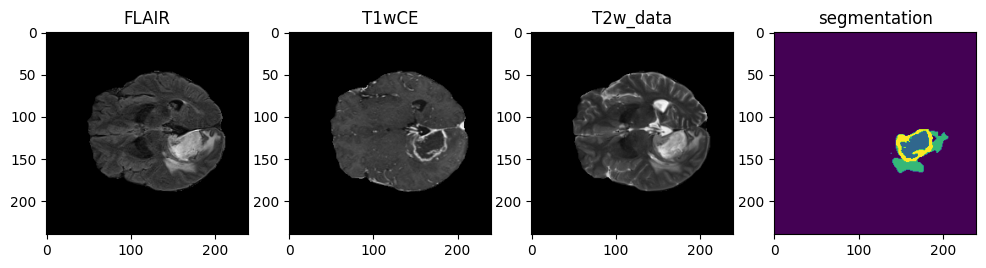

In [23]:
plt.figure(figsize=(12,6))

slice = 70

plt.subplot(141)
plt.title('FLAIR')
plt.imshow(temp_image_flair[:,:,slice], cmap='gray') # we are selecting slice 70 (in total there are 155 per volume)
plt.subplot(142)
plt.title('T1wCE')
plt.imshow(temp_image_t1ce[:,:,slice], cmap='gray')
plt.subplot(143)
plt.title('T2w_data')
plt.imshow(temp_image_t2[:,:,slice], cmap='gray')
plt.subplot(144)
plt.title('segmentation')
plt.imshow(temp_mask[:,:,slice])

- combine three MRI modalities (T2, T1ce, FLAIR) into a single 4D array

In [24]:
temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)
temp_combined_images.shape

(240, 240, 155, 3)

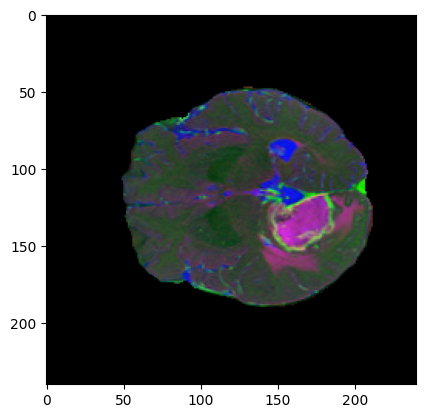

In [25]:
plt.imshow(temp_combined_images[:,:,slice,:])

- crops the images and masks to a size divisible by 64 to facilitate later extraction of 64x64x64 patches


In [26]:
temp_combined_images = temp_combined_images[24:216, 24:216, 13:141] # crop to 192 x 192 x 128 x 3
temp_mask = temp_mask[24:216, 24:216, 13:141]

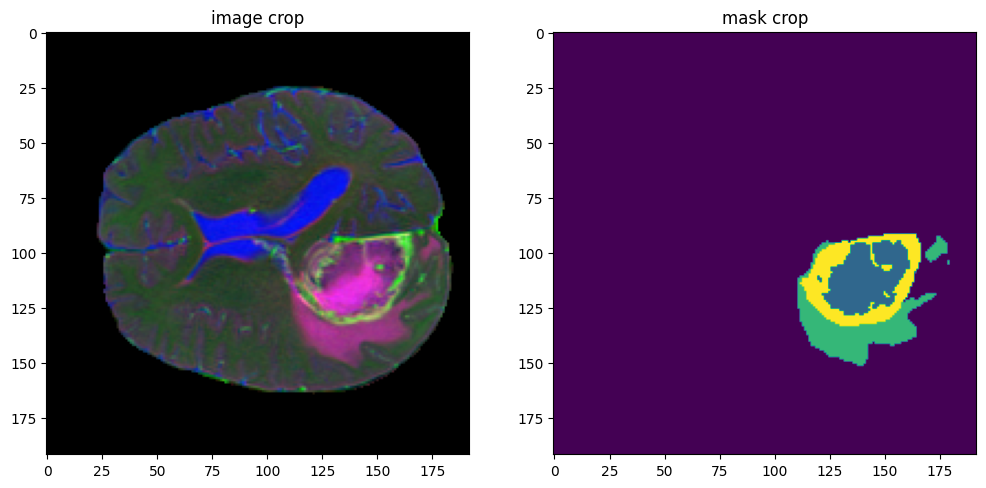

In [27]:
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.title('image crop')
plt.imshow(temp_combined_images[:,:,slice,:])
plt.subplot(122)
plt.title('mask crop')
plt.imshow(temp_mask[:,:,slice])


- checks if the **mask** contains at least 1% useful volume with labels other than 0 and if this condition is met, it converts the masks to categorical format
- saves the image and mask as numpy arrays

such that when I load them again in my code I can treat them as before 

In [28]:
val, counts = np.unique(temp_mask, return_counts=True)  # find the unique elements of an array and count them

In [29]:
if (1 - (counts[0]/counts.sum())) > 0.01:  #At least 1% useful volume with labels that are not 0
    print("Save Me")
    temp_mask_one_hot = torch.zeros((*temp_mask.shape, 4), dtype=torch.float32)
    temp_mask_one_hot.scatter_(3, torch.unsqueeze(torch.tensor(temp_mask, dtype=torch.int64), 3), 1)

    output_dir = 'BraTS2021_TrainingData/input_data_3channels'
    image_dir = os.path.join(output_dir, 'images')
    mask_dir = os.path.join(output_dir, 'masks')
    os.makedirs(image_dir, exist_ok=True)
    os.makedirs(mask_dir, exist_ok=True)
    np.save('BraTS2021_TrainingData/input_data_3channels/images/image_'+str('00211')+'.npy', temp_combined_images)
    np.save('BraTS2021_TrainingData/input_data_3channels/masks/mask_'+str('00211')+'.npy', temp_mask_one_hot)
    
else:
    print("I am useless") 

Save Me


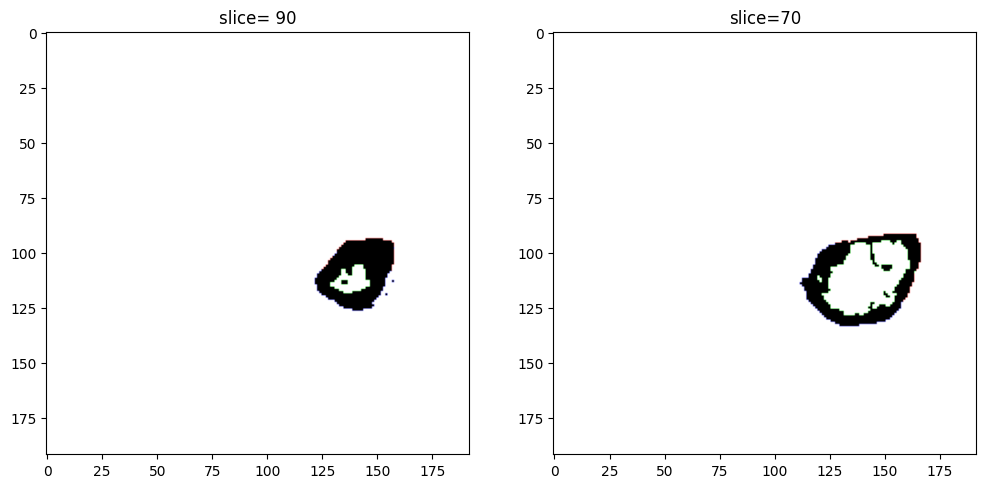

In [30]:
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.title('slice= 90')
plt.imshow(temp_mask_one_hot[:,:,90])
plt.subplot(122)
plt.title('slice=70')
plt.imshow(temp_mask_one_hot[:,:,slice])

In [34]:
my_img=np.load('BraTS2021_TrainingData/input_data_3channels/images/image_00211.npy')
my_mask=np.load('BraTS2021_TrainingData/input_data_3channels/masks/mask_00211.npy')

#my_img.shape --> (192, 192, 128, 3)
#my_mask.shape --> (192, 192, 128, 4) --> with 4th dimension for the 1-hot encoding

(128, 128, 128, 3) (128, 128, 128, 4)


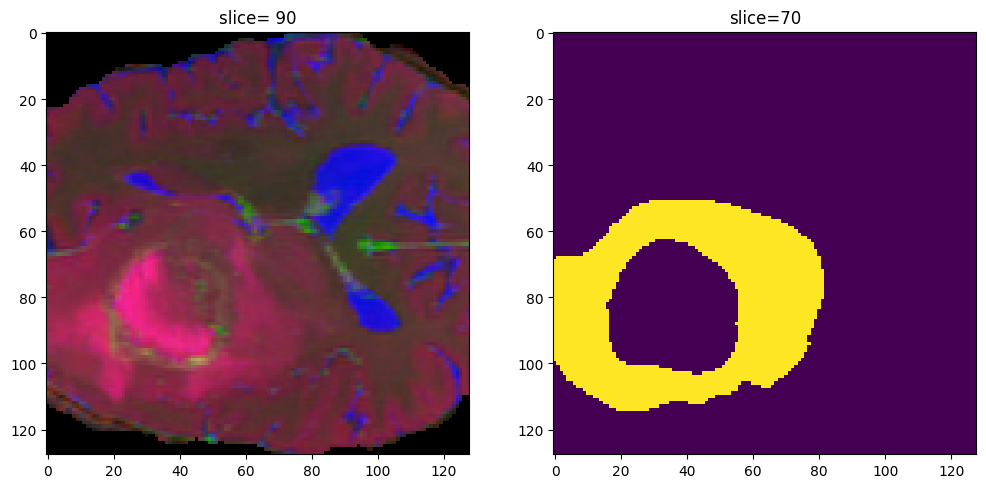

In [35]:
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.title('slice= 90')
plt.imshow(my_img[:,:,slice,:])
plt.subplot(122)
plt.title('slice=70')
plt.imshow(my_mask[:,:,slice,2]) # label 2 